In [11]:
# lib importing and setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.impute import SimpleImputer

# visualization style
sns.set(style="whitegrid")

# directory; to save the results/images
if not os.path.exists('images'):
    os.makedirs('images')
    print("Created 'images' directory.")

print("Libraries loaded. Environment ready.")

Libraries loaded. Environment ready.


In [13]:
# Data cleaning
# connection to db
conn = sqlite3.connect('org_compliance_data.db')
df = pd.read_sql("SELECT * FROM departments", conn)

print(f"Original Data Shape: {df.shape}")

# cleaning target variable
# We cannot use rows where the target 'overall_risk_score' is missing.
df_clean = df.dropna(subset=['overall_risk_score']).copy()

# Feature engineering: defining the target class
# The goal is to identify HIGH RISK departments.
# We define "High Risk" as the top 25% of departments based on their risk score.
threshold = df_clean['overall_risk_score'].quantile(0.75)
df_clean['is_high_risk'] = (df_clean['overall_risk_score'] > threshold).astype(int)

print(f"High Risk Threshold: > {threshold}")
print(f"Data Shape after cleaning target: {df_clean.shape}")

Original Data Shape: (709, 37)
High Risk Threshold: > 34.0
Data Shape after cleaning target: (409, 38)


In [15]:
# Imputation
# Drop Data Leakage & ID columns
# We remove audit scores because we want to predict risk BEFORE the audit happens.
drop_cols = ['dept_id', 'dept_name', 'overall_risk_score', 'is_high_risk', 
             'compliance_score_final', 'audit_score_q1', 'audit_score_q2']

# Separate Numeric and Categorical columns
numeric_cols = df_clean.drop(columns=drop_cols, errors='ignore').select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_clean.drop(columns=drop_cols, errors='ignore').select_dtypes(include=['object']).columns

# Imputation strategy
# for numerical data, we use the Median (robust to outliers).
imputer_num = SimpleImputer(strategy='median')
df_clean[numeric_cols] = imputer_num.fit_transform(df_clean[numeric_cols])

# For categorical data, we fill missing values with 'Unknown'.
imputer_cat = SimpleImputer(strategy='constant', fill_value='Unknown')
df_clean[categorical_cols] = imputer_cat.fit_transform(df_clean[categorical_cols])

print("Missing values handled.")

Missing values handled.


In [17]:
# Preprocessing
# Encode Categorical Variables (Text -> Numbers)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

# Define X (Features) and y (Target)
X = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])
y = df_clean['is_high_risk']

# Scaling
# Important for Logistic Regression performance
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train-Test Split (80% Train, 20% Test)
# We use 'stratify' to ensure the proportion of risky departments is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (327, 31)
Test set: (82, 31)


In [37]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

print("Training models...")

for name, model in models.items():
    # Train the model 
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # calculate metrics
    # F1-Score is crucial here because class balance matters more than simple accuracy
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Storing results
    results[name] = {"F1 Score": f1, "ROC-AUC": auc}
    print(f"✔️ {name} trained. F1: {f1:.3f} | AUC: {auc:.3f}")

Training models...
✔️ Logistic Regression trained. F1: 0.872 | AUC: 0.978
✔️ Random Forest trained. F1: 0.919 | AUC: 0.988
✔️ Gradient Boosting trained. F1: 0.919 | AUC: 0.994


In [21]:
# Hyperparameter Tuning
print("Starting Hyperparameter Tuning for Random Forest...")

# Defining the grid of parameters to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Run Grid Search with Cross-Validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best-best model
best_rf = grid_search.best_estimator_

print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best AUC Score on CV: {grid_search.best_score_:.3f}")

Starting Hyperparameter Tuning for Random Forest...
Best Parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}
Best AUC Score on CV: 0.980


Snapshot saved: images/model_comparison.png


<Figure size 1000x500 with 0 Axes>

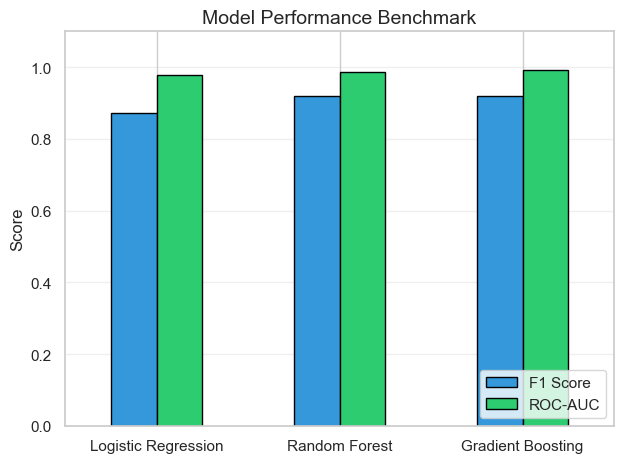

In [29]:
# Results & Saving
# Create a DataFrame from results for plotting
results_df = pd.DataFrame(results).T

plt.figure(figsize=(10, 5))
results_df[['F1 Score', 'ROC-AUC']].plot(kind='bar', color=['#3498db', '#2ecc71'], edgecolor='black')

plt.title("Model Performance Benchmark", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('images/model_comparison.png')
print("Snapshot saved: images/model_comparison.png")
plt.show()

Snapshot saved: images/feature_importance.png


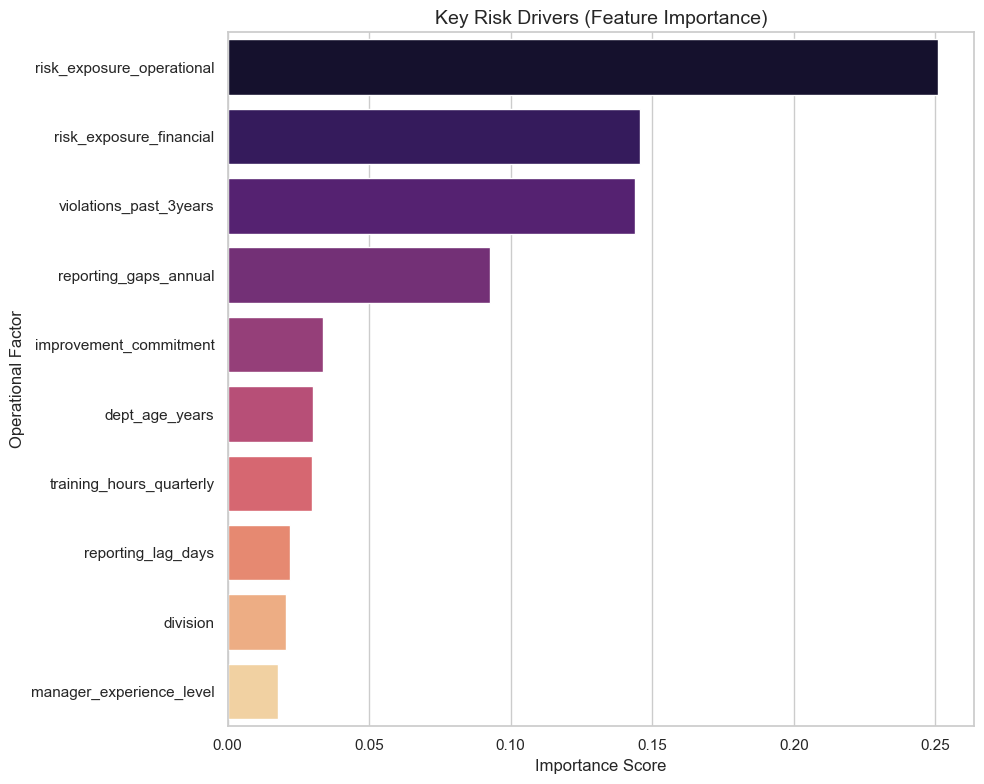

In [35]:
# Feature importance
# extraction feature importances from the optimized Random Forest
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices][:top_n], 
            y=[X.columns[i] for i in indices[:top_n]], 
            hue=[X.columns[i] for i in indices[:top_n]], 
            palette='magma', 
            legend=False)

plt.title("Key Risk Drivers (Feature Importance)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Operational Factor")

plt.tight_layout()
plt.savefig('images/feature_importance.png')
print("Snapshot saved: images/feature_importance.png")
plt.show()